# Transmissibility

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False

First, setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('..'))
from utils import setup_spreadr

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr' + os.path.split(os.path.abspath(os.path.curdir))[1][9:]
setup_spreadr(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_2


Then import all we need for the analysis

In [3]:
from itertools import product

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import numpy as np
from pandas import DataFrame
import seaborn as sb

from gists.models import Sentence, Tree

from utils import grouper, memoized, mpl_palette

Equip our models with useful tools

In [4]:
from utils import equip_spreadr_models as utils_equip
utils_equip()

from linguistics import equip_spreadr_models as linguistics_equip
linguistics_equip()

## 2 Transmissibility of sentences

First generate our data

In [5]:
data = []
order = []
for tree in Tree.objects.experiment.all():
    root = tree.root
    root_length = len(root.content_words)
    order.append({'tree id': tree.id,
                  'root length': root_length})
    for sentence in tree.sentences.kept.all():
        length = len(sentence.content_words)
        for child in sentence.children.kept.all():
            data.append({'tree id': tree.id,
                         'sentence id': sentence.id,
                         'length': length,
                         'root length': root_length,
                         'depth': sentence.depth,
                         'branch id': child.head.id,
                         'transmit success': sentence.ordered_content_distance(child) == 0})
data = DataFrame(data)
root_order = DataFrame(order).sort_values(['root length', 'tree id'])

### 2.1 Quick look at interactions

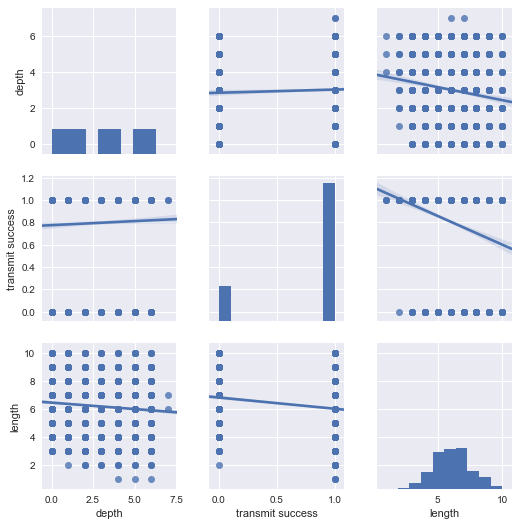

In [6]:
g = sb.pairplot(data=data,
                vars=['depth', 'transmit success', 'length'], kind='reg')
if SAVE_FIGURES:
    g.savefig(FIG.format('depth_transmissibility_length_interactions'), dpi=300)

### 2.2 Transmissibility ~ depth, global

Plotting function to have the evolution of average transmissibility

In [7]:
def plot_transmissibility(data, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    depth_success = data.groupby('depth')['transmit success']

    # Compute transmissibilities per depth
    heights = depth_success.mean()
    cis = depth_success.std() * 1.96 / np.sqrt(depth_success.size() - 1)

    # Plot
    ax = plt.gca()
    ax.plot(heights.index, heights, color=color)
    ax.fill_between(heights.index, heights - cis, heights + cis,
                   color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.set_ylim(0, 1)
    ax.set_xlabel('depth')
    ax.set_ylabel('transmit success')

Evolution of global transmissibility, computed as average per depth and as logistic regression against depth

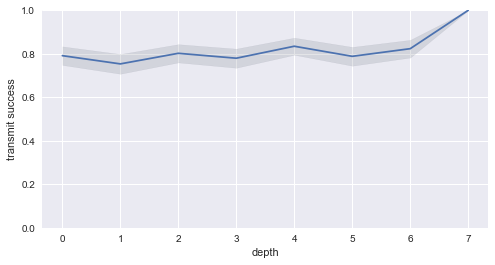

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_transmissibility(data)
if SAVE_FIGURES:
    fig.savefig(FIG.format('transmissibility-global_average'), dpi=300)

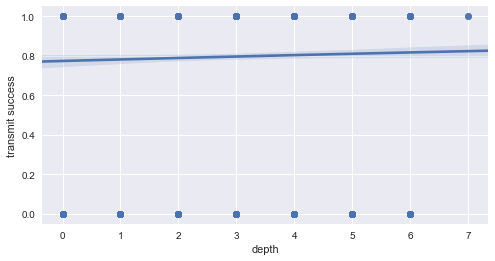

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
sb.regplot('depth', 'transmit success', data=data, logistic=True, ax=ax)
if SAVE_FIGURES:
    fig.savefig(FIG.format('transmissibility-global_logistic'), dpi=300)

### 2.3 Transmissibility ~ depth, per number of content words

As average per depth and as logistic regression

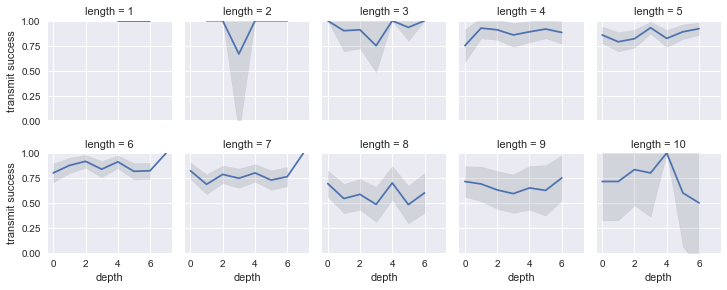

In [10]:
ordered_lengths = sorted(set(data.length.values))
g = sb.FacetGrid(data=data, col='length', col_wrap=5,
                 sharex=True, sharey=True, size=2,
                 col_order=ordered_lengths)
g.map_dataframe(plot_transmissibility)
g.set_xlabels('depth')
g.set_ylabels('transmit success')
if SAVE_FIGURES:
    g.savefig(FIG.format('transmissibility-length_average'), dpi=300)

### 2.4 Transmissibility ~ depth, per tree

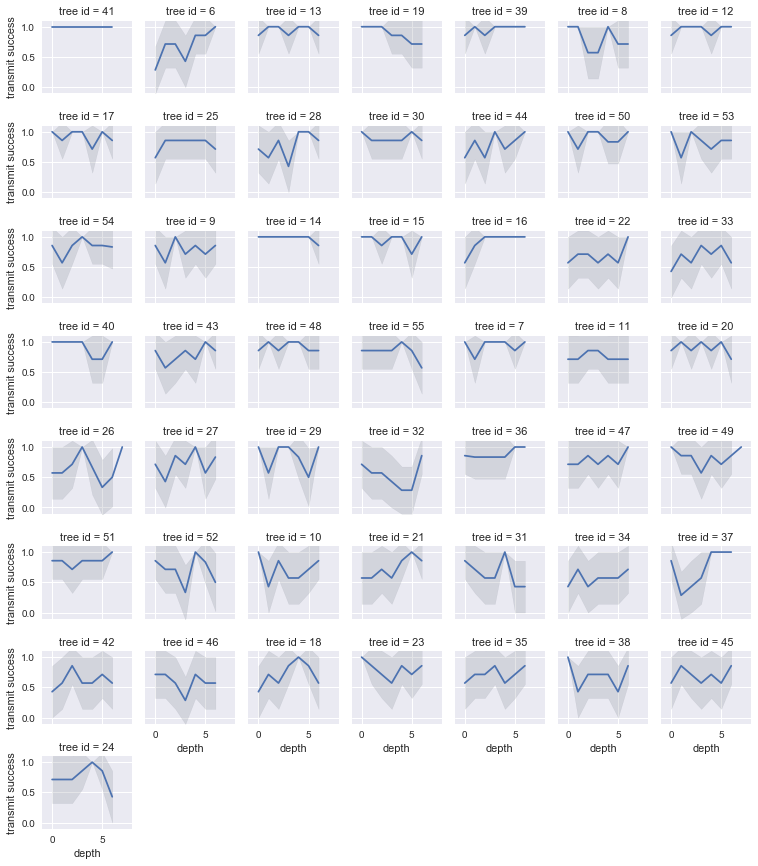

In [11]:
g = sb.FacetGrid(data=data, col='tree id', col_wrap=7,
                 sharex=True, sharey=True, size=1.5,
                 col_order=root_order['tree id'])
g.map_dataframe(plot_transmissibility)
g.set_xlabels('depth')
g.set_ylabels('transmit success')
g.set(xlim=(-1, 8), ylim=(-0.1, 1.1))
if SAVE_FIGURES:
    g.savefig(FIG.format('transmissibility-tree_average'), dpi=300)